# Test for DeepFace and Redis

In [26]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from deepface import DeepFace
from deepface.commons import functions
import redis as rd

### building model

In [27]:
model = DeepFace.build_model("Facenet")
input_shape = (160, 160)
target_shape = 128

### setting up target

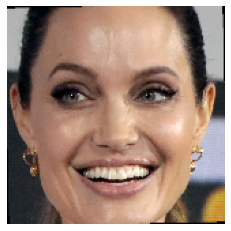

In [28]:
target_img_path = "img1.jpg"
target_img = functions.preprocess_face(target_img_path, target_size=(160, 160))

plt.imshow(target_img[0][:,:,::-1])
plt.axis('off')
plt.show()

target_embedding = model.predict(target_img)[0].tolist()

### setting up redis connection

In [30]:
redis = rd.StrictRedis(host='localhost', port=6379, db=0)
for key in redis.scan_iter("embedding:*"):
    redis.delete(key)
for key in redis.scan_iter("photo:*"):
    redis.delete(key)

ConnectionError: Error 61 connecting to localhost:6379. Connection refused.

### create local db

In [13]:
# Ref: https://github.com/serengil/deepface/tree/master/tests/dataset
local_db = {
    'angelina': 'dataset/img2.jpg',
    'jennifer': 'dataset/img56.jpg',
    'scarlett': 'dataset/img49.jpg',
    'katy': 'dataset/img42.jpg',
    'marissa': 'dataset/img23.jpg'
}

identities = list(local_db.keys())

for i in tqdm(range(0, len(identities))):
    name = identities[i]
    img_path = local_db[name]
    img = functions.preprocess_face(img_path, target_size=(160, 160))
    embedding = model.predict(img)[0].tolist() 
    redis.rpush("embedding:"+name, *embedding)
    redis.set("photo:"+name, img_path)

100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


### custom distance function

In [14]:
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

### client-side face verification

Distance is  8.136595241701153


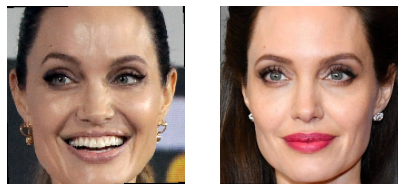

this is angelina
Distance is  16.721210127890153


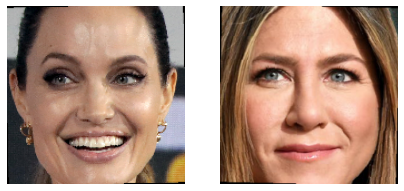

this IS NOT jennifer
Distance is  14.439996296031032


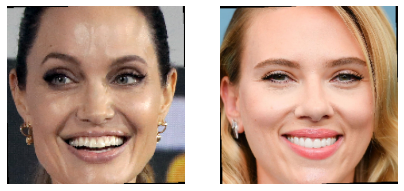

this IS NOT scarlett
Distance is  14.991689761995048


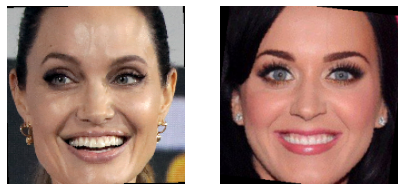

this IS NOT katy
Distance is  14.938900667587134


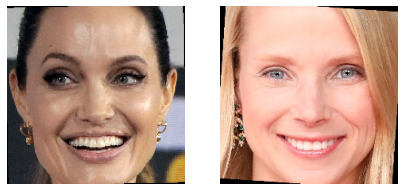

this IS NOT marissa


In [15]:
def verify_face(key):
    embedding = redis.lrange('embedding:'+key, 0, -1)
    distance = findEuclideanDistance(target_embedding, np.array(embedding).astype('float'))
    print("Distance is ", distance)
    img_name = redis.get('photo:'+key).decode()
    source_img = functions.preprocess_face(img_name)
        
    fig = plt.figure(figsize = (7, 7))
    ax1 = fig.add_subplot(1,2,1)
    plt.imshow(target_img[0][:, :, ::-1])
    plt.axis('off')
    ax2 = fig.add_subplot(1,2,2)
    plt.imshow(source_img[0][:, :, ::-1])
    plt.axis('off')
    plt.show()
        
    if distance <= 10:
        print("this is "+key)
    else:
        print("this IS NOT "+key)

people = ['angelina', 'jennifer', 'scarlett', 'katy', 'marissa']
for p in people:
    verify_face(p)

### server-side face verification

In [16]:
verify_script = '''
    local source = KEYS[1]
    local source_embedding = redis.call("lrange", "embedding:"..source, 0, -1)

    local distance = 0
    for i = 1, #source_embedding do
        distance = distance + (source_embedding[i] - KEYS[1+i])^2
    end

    distance = math.sqrt(distance)

    return {"euclidean_distance", tostring(distance)}
    '''

command = redis.register_script(verify_script)
for p in people:
    print(float(command(keys=[p, *target_embedding])[1].decode()) <= 10)

True
False
False
False
False


### server-side face recognition

In [17]:
find_script = '''
    local db = redis.call("SCAN", 0, "MATCH", "embedding:*")[2]

    local identities = {}
    local distances = {}

    local idx = 1
    for i=1, #db do
        local source_key = db[i]
        local source_embedding = redis.call("lrange", source_key, 0, -1)
        
        local distance = 0
        for j=1, #source_embedding do
            distance = distance + (source_embedding[j] - KEYS[j])^2
        end
        
        distance = math.sqrt(distance)
        
        if distance <= 10 then
            distances[idx] = tostring(distance)
            identities[idx] = source_key
            idx = idx + 1
        end
        
    end

    return {identities, distances}
    '''

command = redis.register_script(find_script)
results = command(keys = [*target_embedding])
print(results)

[[b'embedding:angelina'], [b'8.1365952417012']]


In [21]:
for key in redis.scan_iter():
    print(key)

ConnectionError: Error 61 connecting to localhost:6379. Connection refused.